# Banco de Dados - A2 

## I - Carregando os dados capturados

Capturamos 3 arquivos geojson que serão utilizados para a nossa tarefa:

+ [Arquivo do perímetro do estado do Piauí](https://github.com/tbrugz/geodata-br)
+ [Arquivo com municípios atingidos por seca em 2015](https://dados.gov.br/dataset/municipios-atingidos-por-eventos-de-seca-em-2015)
+ [Arquivo com o percentual de moradores em domicílios particulares com 1 a 2 salários](https://dados.gov.br/dataset/cgeo_vw_perc_morad_rend_1_a_2)

In [1]:
import json #carregaremos os geojsons em dicionários
import geojson

#arquivo geojson piaui

f = open('piaui.geojson')
data1 = geojson.load(f)
f.close()

#arquivo geojson secas

f = open('seca2015.geojson')
data2 = geojson.load(f)
f.close()

#arquivo geojson renda

f = open('rend_1_2.geojson')
data3 = geojson.load(f)
f.close()

## II - Criando o banco de dados

Vamos criar um banco de dados NoSQL no Mongodb e armazenar os dados nele

In [14]:
import datetime
import pprint

import pymongo
from pymongo import MongoClient

In [15]:
client = MongoClient('localhost', 27017)

### Criação do banco e das coleções

In [16]:
#criando o banco

db = client.a2_database

#criando as coleções

collection1 = db.piaui_data 
collection2 = db.secas_data
collection3 = db.renda_data


A seguir, iremos inserir os documentos dos arquivos que capturamos nas coleções criadas, como sugerido pelos nomes das mesmas.

### Armazenando os documentos no banco de dados

In [21]:
#a série de documentos de cada geojson está na chave 'feature' de cada dict que carregamos anteriormente

piaui_features = data1['features']
secas_features = data2['features']
renda_features = data3['features']

#agora vamos adicionar os documentos às coleções e salvar os ids em 3 variáveis, como vimos em aula

results1 = collection1.insert_many(piaui_features)
results2 = collection2.insert_many(secas_features)
results3 = collection3.insert_many(renda_features)


Verificando se as coleções e o banco já aparecem, para ter certeza de que os documentos foram adicionados

In [22]:
print(client.list_database_names())
print(db.list_collection_names())

['a2_database', 'admin', 'config', 'local', 'test_database']
['renda_data', 'secas_data', 'piaui_data']



Só pra ter **realmente** certeza que adicionamos corretamente, vamos fazer uma querry procurando nossa cidade na coleção com os municípios do Piauí

In [23]:
collection1.find_one({'properties.name': 'Cocal dos Alves'})

{'_id': ObjectId('61b8226e0ec09d90e54d8d70'),
 'type': 'Feature',
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-41.395173, -3.547111],
    [-41.36712, -3.561546],
    [-41.370871, -3.567419],
    [-41.370251, -3.574492],
    [-41.361633, -3.582805],
    [-41.352863, -3.585212],
    [-41.344529, -3.588364],
    [-41.330941, -3.62431],
    [-41.338723, -3.670045],
    [-41.343318, -3.675598],
    [-41.341373, -3.680397],
    [-41.326168, -3.686944],
    [-41.30729, -3.684428],
    [-41.290426, -3.689314],
    [-41.27896, -3.700372],
    [-41.255058, -3.702885],
    [-41.238965, -3.71227],
    [-41.239056, -3.720374],
    [-41.251515, -3.722964],
    [-41.256989, -3.729525],
    [-41.260809, -3.757167],
    [-41.278219, -3.769624],
    [-41.312905, -3.739048],
    [-41.334431, -3.69084],
    [-41.370712, -3.717975],
    [-41.410521, -3.747756],
    [-41.442123, -3.771403],
    [-41.455065, -3.719474],
    [-41.429378, -3.708816],
    [-41.433044, -3.698321],
    [-41.433635, -3.69

## III - Análise utilizando [geopandas](https://geopandas.org/en/stable/)

Agora iremos fazer uma análise dos dados utilizando geopandas.

Para isso, transformaremos as coleções em GeoDataFrames do geopandas:

In [2]:
#Importando bibliotecas necessárias para a análise (vimos na enciclopédia de python do professor)
#https://github.com/rsouza/FGV_Intro_DS/blob/master/notebooks/Tasks_Mapping_Geopandas.ipynb

import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import descartes
import rtree 

import geopandas as gpd
from geopandas.tools import geocode

from shapely.geometry import LineString, MultiPolygon, shape

import folium
from folium import Choropleth, Circle, Marker, GeoJson
from folium.plugins import HeatMap, MarkerCluster

from IPython.display import Image, HTML, IFrame, FileLink, FileLinks 
from IPython.core.display import display

### Obtendo GeoDataFrames dos dados que carregamos anteriormente

In [3]:
#df limites municípios do piauí
gdf_piaui = gpd.GeoDataFrame(data1['features'])

#df municípios que sofreram com seca em 2015
gdf_secas = gpd.GeoDataFrame(data2['features'])

#df qntd pessoas com 1 a 2 rendas que moram em domicílios particulares
gdf_renda = gpd.GeoDataFrame(data3['features'])

Dando uma olhadinha...

In [26]:
print(type(gdf_piaui))
gdf_piaui.head()

<class 'geopandas.geodataframe.GeoDataFrame'>


,type,geometry,properties,_id
0,Feature,"POLYGON ((-40.95978 -8.10661, -40.95798 -8.111...","{'id': '2200053', 'name': 'Acauã', 'descriptio...",61b8226e0ec09d90e54d8d36
1,Feature,"POLYGON ((-42.67126 -5.71153, -42.66951 -5.716...","{'id': '2200103', 'name': 'Agricolândia', 'des...",61b8226e0ec09d90e54d8d37
2,Feature,"POLYGON ((-42.66187 -5.95199, -42.68579 -5.958...","{'id': '2200202', 'name': 'Água Branca', 'desc...",61b8226e0ec09d90e54d8d38
3,Feature,"POLYGON ((-40.88404 -6.78987, -40.88244 -6.792...","{'id': '2200251', 'name': 'Alagoinha do Piauí'...",61b8226e0ec09d90e54d8d39
4,Feature,"POLYGON ((-40.78886 -7.11598, -40.78030 -7.133...","{'id': '2200277', 'name': 'Alegrete do Piauí',...",61b8226e0ec09d90e54d8d3a


### Deixando os GeoDataFrames prontos para análise

Como vimos na pŕevia acima, os gdf ainda estão apresentando uma coluna properties com as informações importantes para as análises, então, nessa seção estaremos apenas deixando eles prontos para que possamos começar.

_Ignore esta parte_

In [5]:
gdf_piaui['properties'][0]

{'id': '2200053', 'name': 'Acauã', 'description': 'Acauã'}

In [9]:
gdf_piaui['municipio'] = gdf_piaui['properties'].apply(lambda x: x['name'])

In [10]:
gdf_piaui.head()

,type,geometry,properties,municipio
0,Feature,"POLYGON ((-40.95978 -8.10661, -40.95798 -8.111...","{'id': '2200053', 'name': 'Acauã', 'descriptio...",Acauã
1,Feature,"POLYGON ((-42.67126 -5.71153, -42.66951 -5.716...","{'id': '2200103', 'name': 'Agricolândia', 'des...",Agricolândia
2,Feature,"POLYGON ((-42.66187 -5.95199, -42.68579 -5.958...","{'id': '2200202', 'name': 'Água Branca', 'desc...",Água Branca
3,Feature,"POLYGON ((-40.88404 -6.78987, -40.88244 -6.792...","{'id': '2200251', 'name': 'Alagoinha do Piauí'...",Alagoinha do Piauí
4,Feature,"POLYGON ((-40.78886 -7.11598, -40.78030 -7.133...","{'id': '2200277', 'name': 'Alegrete do Piauí',...",Alegrete do Piauí


In [6]:
gdf_secas.head()

,type,geometry,properties
0,Feature,"POLYGON ((-61.40930 2.02290, -61.41369 2.02543...","{'OBJECTID': 1, 'NM_MUNICIP': 'CARACARAÍ', 'CD..."
1,Feature,"POLYGON ((-61.33730 4.31159, -61.33787 4.31250...","{'OBJECTID': 2, 'NM_MUNICIP': 'AMAJARI', 'CD_G..."
2,Feature,"POLYGON ((-63.61441 3.73768, -63.62546 3.74067...","{'OBJECTID': 3, 'NM_MUNICIP': 'ALTO ALEGRE', '..."
3,Feature,"POLYGON ((-59.88384 3.56296, -59.88578 3.56379...","{'OBJECTID': 4, 'NM_MUNICIP': 'BONFIM', 'CD_GE..."
4,Feature,"POLYGON ((-60.56198 2.87580, -60.56196 2.87629...","{'OBJECTID': 5, 'NM_MUNICIP': 'CANTÁ', 'CD_GEO..."


In [7]:
gdf_secas['properties'][0]

{'OBJECTID': 1,
 'NM_MUNICIP': 'CARACARAÍ',
 'CD_GEOCMU': '1400209',
 'NM_ESTADO': 'RORAIMA',
 'SECAS2015': 1}

In [12]:
gdf_secas['municipio'] = gdf_secas['properties'].apply(lambda x: x['NM_MUNICIP'])
gdf_secas['estado'] = gdf_secas['properties'].apply(lambda x: x['NM_ESTADO'])
gdf_secas['n_secas'] = gdf_secas['properties'].apply(lambda x: x['SECAS2015'])

In [13]:
gdf_secas.head()

,type,geometry,properties,municipio,estado,n_secas
0,Feature,"POLYGON ((-61.40930 2.02290, -61.41369 2.02543...","{'OBJECTID': 1, 'NM_MUNICIP': 'CARACARAÍ', 'CD...",CARACARAÍ,RORAIMA,1
1,Feature,"POLYGON ((-61.33730 4.31159, -61.33787 4.31250...","{'OBJECTID': 2, 'NM_MUNICIP': 'AMAJARI', 'CD_G...",AMAJARI,RORAIMA,1
2,Feature,"POLYGON ((-63.61441 3.73768, -63.62546 3.74067...","{'OBJECTID': 3, 'NM_MUNICIP': 'ALTO ALEGRE', '...",ALTO ALEGRE,RORAIMA,1
3,Feature,"POLYGON ((-59.88384 3.56296, -59.88578 3.56379...","{'OBJECTID': 4, 'NM_MUNICIP': 'BONFIM', 'CD_GE...",BONFIM,RORAIMA,1
4,Feature,"POLYGON ((-60.56198 2.87580, -60.56196 2.87629...","{'OBJECTID': 5, 'NM_MUNICIP': 'CANTÁ', 'CD_GEO...",CANTÁ,RORAIMA,1


In [14]:
gdf_renda.head()

,type,geometry_name,bbox,id,geometry,properties
0,Feature,geom,"[-41.75825089, -15.25299934, -41.2125879, -14....",vw_perc_morad_rend_1_a_2.fid-24ded500_17dab982...,"MULTIPOLYGON (((-41.45880 -14.78142, -41.45497...","{'gid': 215, 'UF': 'BAHIA', 'nome': 'Tremedal'..."
1,Feature,geom,"[-52.30845944, -31.58952968, -52.00608251, -31...",vw_perc_morad_rend_1_a_2.fid-24ded500_17dab982...,"MULTIPOLYGON (((-52.03535 -31.56751, -52.04061...","{'gid': 306, 'UF': 'RIO GRANDE DO SUL', 'nome'..."
2,Feature,geom,"[-40.36233224, -20.51660017, -28.83590763, -20...",vw_perc_morad_rend_1_a_2.fid-24ded500_17dab982...,"MULTIPOLYGON Z (((-40.32926 -20.23997 0.00000,...","{'gid': 900, 'UF': 'ESPIRITO SANTO', 'nome': '..."
3,Feature,geom,"[-46.71524378, -22.38551766, -46.48063771, -22...",vw_perc_morad_rend_1_a_2.fid-24ded500_17dab982...,"MULTIPOLYGON (((-46.50528 -22.34001, -46.51575...","{'gid': 3613, 'UF': 'MINAS GERAIS', 'nome': 'J..."
4,Feature,geom,"[-43.00527809, -5.56170307, -42.75274961, -5.3...",vw_perc_morad_rend_1_a_2.fid-24ded500_17dab982...,"POLYGON Z ((-42.82668 -5.34803 0.00000, -42.82...","{'gid': 1028, 'UF': 'PIAUÍ', 'nome': 'Nazária'..."


In [17]:
gdf_renda['properties'][0]

{'gid': 215,
 'UF': 'BAHIA',
 'nome': 'Tremedal',
 'Censo': '2010',
 'Morad_rend_1_a_2': 844,
 'PERC_Morad_rend_1_a_2': 4.958289,
 'Descrição': 'Percentual de moradores em domicílios particulares permanentes com mais de 1 a 2 salários mínimos de rendimento domiciliar nominal mensal per capita na população de moradores em domicílios particulares permanentes',
 'legenda': ' - 9.09%',
 'classe': 1}

In [18]:
gdf_renda['estado'] = gdf_renda['properties'].apply(lambda x: x['UF'])
gdf_renda['municipio'] = gdf_renda['properties'].apply(lambda x: x['nome'])
gdf_renda['censo'] = gdf_renda['properties'].apply(lambda x: x['Censo'])
gdf_renda['n_morad_renda'] = gdf_renda['properties'].apply(lambda x: x['Morad_rend_1_a_2'])
gdf_renda['perc_morad_renda'] = gdf_renda['properties'].apply(lambda x: x['PERC_Morad_rend_1_a_2'])
gdf_renda['legenda'] = gdf_renda['properties'].apply(lambda x: x['legenda'])

In [19]:
gdf_renda.head()

,type,geometry_name,bbox,id,geometry,properties,estado,municipio,censo,n_morad_renda,perc_morad_renda,legenda
0,Feature,geom,"[-41.75825089, -15.25299934, -41.2125879, -14....",vw_perc_morad_rend_1_a_2.fid-24ded500_17dab982...,"MULTIPOLYGON (((-41.45880 -14.78142, -41.45497...","{'gid': 215, 'UF': 'BAHIA', 'nome': 'Tremedal'...",BAHIA,Tremedal,2010,844,4.958289,- 9.09%
1,Feature,geom,"[-52.30845944, -31.58952968, -52.00608251, -31...",vw_perc_morad_rend_1_a_2.fid-24ded500_17dab982...,"MULTIPOLYGON (((-52.03535 -31.56751, -52.04061...","{'gid': 306, 'UF': 'RIO GRANDE DO SUL', 'nome'...",RIO GRANDE DO SUL,Turuçu,2010,621,17.692308,16.72% - 24.56%
2,Feature,geom,"[-40.36233224, -20.51660017, -28.83590763, -20...",vw_perc_morad_rend_1_a_2.fid-24ded500_17dab982...,"MULTIPOLYGON Z (((-40.32926 -20.23997 0.00000,...","{'gid': 900, 'UF': 'ESPIRITO SANTO', 'nome': '...",ESPIRITO SANTO,Vitória,2010,68015,20.817009,16.72% - 24.56%
3,Feature,geom,"[-46.71524378, -22.38551766, -46.48063771, -22...",vw_perc_morad_rend_1_a_2.fid-24ded500_17dab982...,"MULTIPOLYGON (((-46.50528 -22.34001, -46.51575...","{'gid': 3613, 'UF': 'MINAS GERAIS', 'nome': 'J...",MINAS GERAIS,Jacutinga,2010,6533,28.861107,24.56% - 33.66%
4,Feature,geom,"[-43.00527809, -5.56170307, -42.75274961, -5.3...",vw_perc_morad_rend_1_a_2.fid-24ded500_17dab982...,"POLYGON Z ((-42.82668 -5.34803 0.00000, -42.82...","{'gid': 1028, 'UF': 'PIAUÍ', 'nome': 'Nazária'...",PIAUÍ,Nazária,2010,284,3.528389,- 9.09%


### Começando as análises

#### Primeiro vamos analisar o nosso geodataframe de municípios que sofreram com a seca em 2015.

In [42]:
# Escolhendo apenas as colunas importantes, já que não precisamos de todas no momento
secas_anl = gdf_secas.loc[:, ["municipio", "estado","n_secas", "geometry"]].copy()

+ __Qual estado teve mais municípios que sofreram com seca?__

In [44]:
#plt.hist(secas_anal['estado'], edgecolor='black')
secas_anl.estado.value_counts()

PARAÍBA                197
CEARÁ                  153
RIO GRANDE DO NORTE    153
PIAUÍ                  152
BAHIA                  134
PERNAMBUCO             126
MINAS GERAIS            94
ALAGOAS                 38
ESPÍRITO SANTO          28
RIO GRANDE DO SUL       11
RORAIMA                  8
SERGIPE                  8
MARANHÃO                 2
RIO DE JANEIRO           2
Name: estado, dtype: int64

Obviamente, os estados liderando o ranking de mais municípios que sofreram com seca são da região Nordeste.

Vemos que o estado com mais municípios que sofreram de seca é o estado da Paraíba. Vamos dar uma olhada nele junto com o Piauí(apenas por ser o estado que a moramos).

In [66]:
paraiba_secas = secas_anl.loc[secas_anl['estado'].isin(['PARAÍBA'])].copy()
piaui_secas = secas_anl.loc[secas_anl['estado'].isin(['PIAUÍ'])].copy()

<AxesSubplot:>

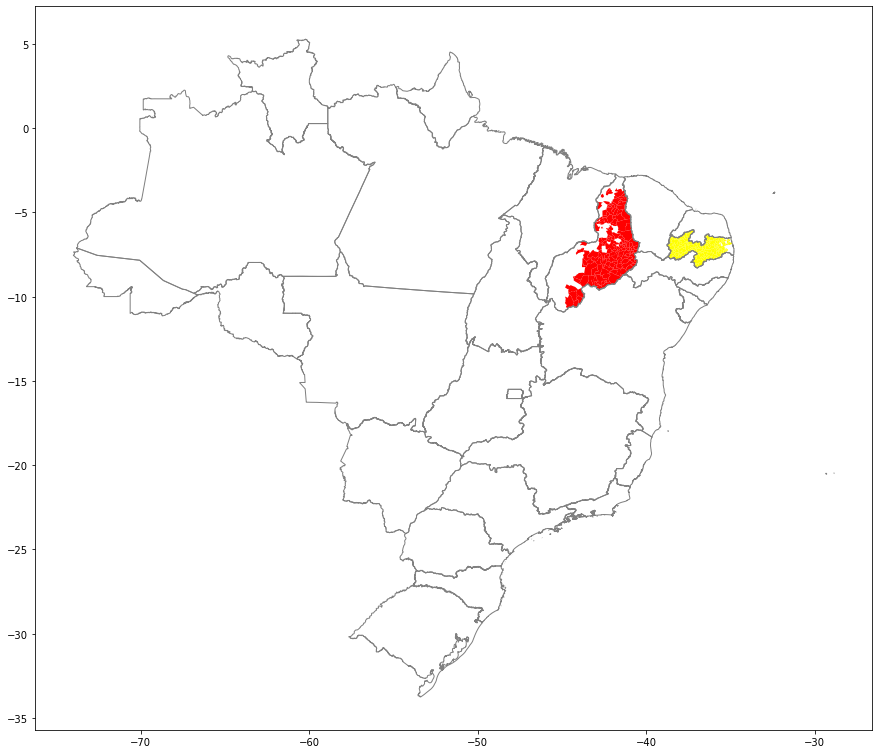

In [88]:
#Limites do Brasil
counties = gpd.read_file("BR_UF_2020.shx")

#Só para deixar os plots mais bonitos vamos salvar uma geodataframe do Brasil, separado por UF
brasil = gpd.read_file("BR_UF_2020.shx")

#Definindo o limite no plot
ax = counties.plot(figsize=(15,15), color='none', edgecolor='gray', zorder=3)


piaui_secas.plot(color = 'red', ax = ax )
paraiba_secas.plot(color = 'yellow', ax = ax )

Podemos ver que grande parte do Piauí sofreu com seca e Paraíba foi quase totalmente atingida.


É importante observar que os municípios que sofreram com seca podem ter sofrido mais de uma seca no ano.

+ __Qual dos dois estados teve maior número de municípios atingidos com mais de 1 seca?__

Vamos verificar qual número máximo de secas um município teve e em seguida ver separadamente para ambos estados:

In [89]:
secas_anl['n_secas'].value_counts()

1    659
2    447
Name: n_secas, dtype: int64

Note que, no máximo, um município sofreu duas secas em 2015. Vamos dar uma olhada nessa proporção por meio de um mapa dos estados:

In [83]:
#Separando os municípios que sofreram de somente 1 seca e os que sofreram 2 para ambos estados
pi_sec_1 = piaui_secas.loc[piaui_secas['n_secas'] == 1]
pi_sec_2 = piaui_secas.loc[piaui_secas['n_secas'] == 2]

pb_sec_1 = paraiba_secas.loc[paraiba_secas['n_secas'] == 1]
pb_sec_2 = paraiba_secas.loc[paraiba_secas['n_secas'] == 2]

<AxesSubplot:>

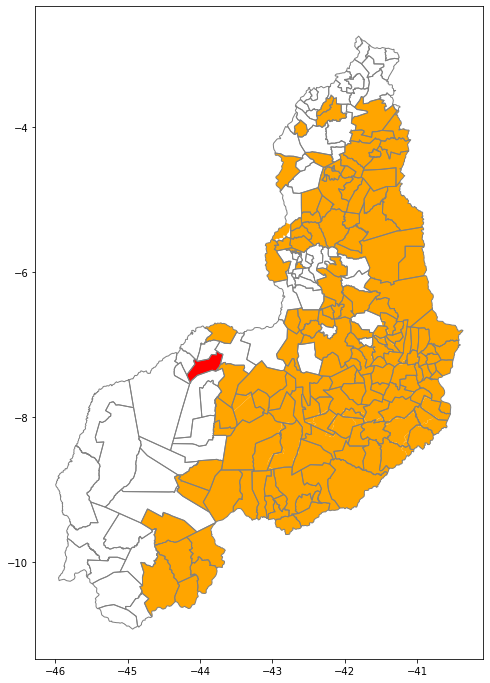

In [87]:
#plotando 
#Tomando o limite do plot como o estado do piauí.
counties = gdf_piaui
ax = counties.plot(figsize=(12,12), color='none', edgecolor='gray', zorder=3)

#Definindo a coloração dos municípios que sofreram 1 seca como laranja
pi_sec_1.plot(color = 'orange', ax = ax)
#Definindo a coloração dos municípios que sofreram 2 secas como vermelho
pi_sec_2.plot(color = 'red', ax = ax)

Interessante, vemos que apenas 1 município do Piauí sofreu com duas secas em 2015.

Agora vamos observar Paraíba.

<AxesSubplot:>

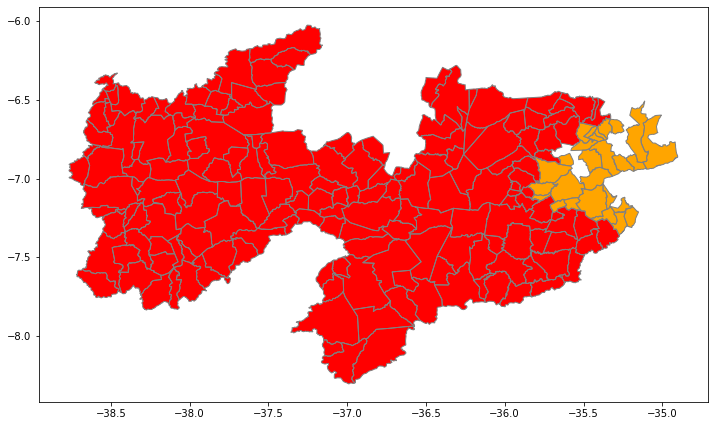

In [93]:
#plotando 
#Tomando o limite do plot como o estado de Paraíba.
counties = paraiba_secas
ax = counties.plot(figsize=(12,12), color='none', edgecolor='gray', zorder=3)

#Definindo a coloração dos municípios que sofreram 1 seca como laranja
pb_sec_1.plot(color = 'orange', ax = ax)
#Definindo a coloração dos municípios que sofreram  2 secas como vermelho
pb_sec_2.plot(color = 'red', ax = ax)

Como pudemos ver no mapa, Paraíba foi seriamente atingida pela seca em 2015, quase todo o estado apresentou o fenômeno.

Comparado ao Piauí, Paraíba teve muito mais municípios que sofreram com mais de uma seca, que ano terrível!

#### Agora vamos analisar o nosso geodataframe com o percentual de moradores em domicílios particulares com 1 a 2 salários

In [95]:
# Escolhendo apenas as colunas importantes, já que não precisamos de todas no momento
renda_anl = gdf_renda.loc[:, ["municipio", "estado","censo","n_morad_renda","perc_morad_renda", "legenda", "geometry"]].copy()

Temos dados de quase todo o Brasil nesse documento, como podemos ver no plot abaixo:

<AxesSubplot:>

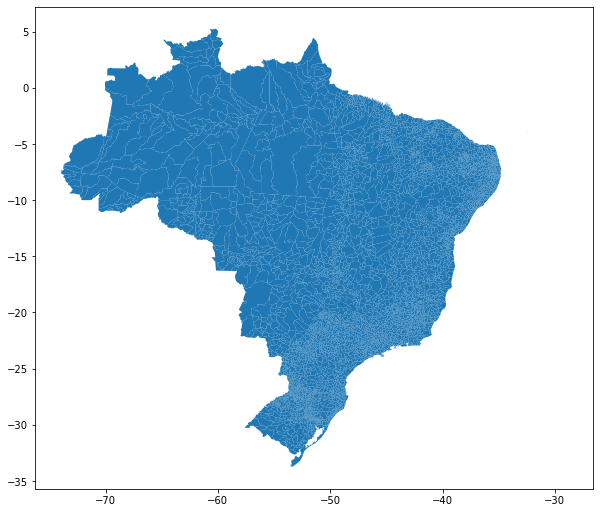

In [107]:
renda_anl.plot(figsize = (10,10))

Uma pergunta interessante seria __"Qual município tem o maior percentual de pessoas que moram em domicílios particulares com 1 a 2 salários?"__

Usando pandas para responder:

In [108]:
#Encontrando o índice onde o percentual máximo está
renda_anl['perc_morad_renda'].idxmax()

432

In [118]:
municip_renda = renda_anl['municipio'][432]
estado_renda = renda_anl['estado'][432]
porcentagem_renda = renda_anl['perc_morad_renda'][432]
print(f"O município com maior percentual de pessoas que moram em domicílios particulares com 1 a 2 salários é {municip_renda} no estado de {estado_renda}, com um percentual de {porcentagem_renda}!")

O município com maior percentual de pessoas que moram em domicílios particulares com 1 a 2 salários é São Vendelino no estado de RIO GRANDE DO SUL, com um percentual de 53.62841!


In [115]:
#Calculando a quantidade de pessoas
renda_anl['n_morad_renda'][432]

1042

Muito interessante! Mais da metade da população que morava em domicílio particular em São Vendelino tinha
renda de 1 a 2 salários mínimos.

Isso pode ter ocorrido por São Vendelino ser uma cidade pequena, em 2010 tinha apenas 1944 habitantes.

Outra boa pergunta seria

+ __Qual estado tem maior quantidade de pessoas que moram em domicílios particulares e tem 1 ou 2 salários?__

Podemos responder essa pergunta utilizando as ferramentas do pandas no nosso GeoDataFrame:

In [127]:
# Escolhendo só as colunas importantes para a resposta
estado_n_renda = renda_anl.loc[:, ["estado","n_morad_renda"]].copy()

In [134]:
# Calculando quantas pessoas moram em domicílios particulares e tem 1 ou 2 salários para cada estado
estado_n_renda.groupby('estado')['n_morad_renda'].sum()

estado
ACRE                      89049
ALAGOAS                  257086
AMAPÁ                     94174
AMAZONAS                 397794
BAHIA                   1381167
CEARÁ                    738430
DISTRITO FEDERAL         521320
ESPIRITO SANTO           734813
GOIÁS                   1325041
MARANHÃO                 466734
MATO GROSSO              648723
MATO GROSSO DO SUL       516830
MINAS GERAIS            3955737
PARANÁ                  2714016
PARAÍBA                  357296
PARÁ                     724425
PERNAMBUCO               884241
PIAUÍ                    271750
RIO DE JANEIRO          3462320
RIO GRANDE DO NORTE      376172
RIO GRANDE DO SUL       2943027
RONDÔNIA                 291000
RORAIMA                   59412
SANTA CATARINA          2115409
SERGIPE                  217966
SÃO PAULO              11264535
TOCANTINS                183331
Name: n_morad_renda, dtype: int64

In [136]:
estado_n_renda.groupby('estado')['n_morad_renda'].sum().idxmax()

'SÃO PAULO'

Bem, era de se esperar que a resposta fosse São Paulo, já que é o estado com maior população do Brasil e maior 
quantidade de trabalhadores([IBGE](https://pt.wikipedia.org/wiki/Lista_de_unidades_federativas_do_Brasil_por_porcentagem_de_empregados_com_carteira_de_trabalho_assinada)). Além disso, maioria dos trabalhadores de SP se encontram em empregos que não
são grandemente remunerados.

<AxesSubplot:>

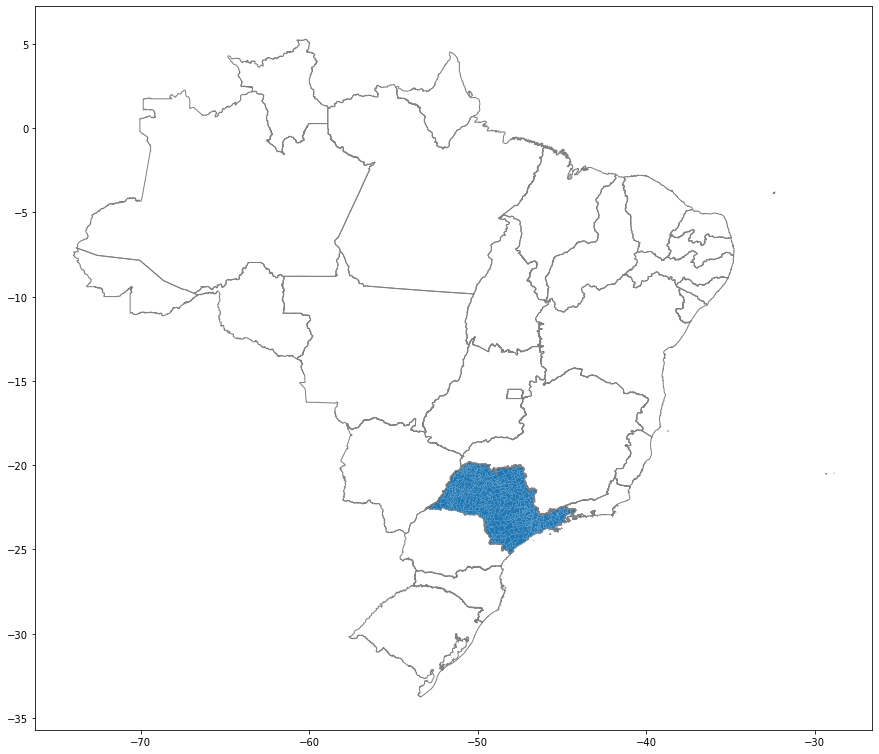

In [141]:
sao_paulo = renda_anl.loc[renda_anl['estado'].isin(['SÃO PAULO'])].copy()
#definindo o limite do plot como o Brasil 
counties = brasil
ax = counties.plot(figsize=(15,15), color='none', edgecolor='gray', zorder=3)

sao_paulo.plot(figsize = (30,30), ax = ax)

Note que em praticamente todos os municípios de São Paulo há pessoas que tem a característica procurada.